# Deep $Q$-learning

In this notebook, I'll build a neural network that can learn to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](cart-pole.jpg)

In [1]:
import gym
import numpy as np

# Create the Cart-Pole game environment
env = gym.make('CartPole-v1')

# environment details
print('Number of possible actions:', env.action_space.n)
print('States:', env.observation_space)
print(env.observation_space.low)
print(env.observation_space.high)

Number of possible actions: 2
States: Box(4,)
[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38]
[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38]


In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

In [2]:
from time import sleep


actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, _ = env.step(action) 
    env.render()
    sleep(0.05)
    rewards.append(reward)
    actions.append(action)
    if done:
        env.close()
        break
        
print('Actions:', actions)
print('Rewards:', rewards)

Actions: [0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0]
Rewards: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


The game resets after the pole has fallen past a certain angle. For each step while the game is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. The network's goal is to maximize the reward by keeping the pole vertical.

## $Q$-Network

The neural network accepts a state $s$ as input and the output will be $Q$-values for each available action $a$.

For this Cart-Pole game, the state has four values: the position and velocity of the cart, and the position and velocity of the pole.  Thus, the neural network has **four inputs**, one for each value in the state, and **two outputs**, one for each possible action. 

Below is one implementation of the $Q$-network that uses 3 fully connected layers with ReLU activations.

In [3]:
import tensorflow as tf

class QNetwork:
    def __init__(self, learning_rate=0.01, state_size=4, 
                 action_size=2, hidden_size=10, 
                 name='QNetwork'):
        with tf.variable_scope(name):
            # state inputs to the Q-network
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc3, action_size, 
                                                            activation_fn=None)
            
            ### Train using mean squared error and Adam gradient descent.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

## Experience replay

To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

This `Memory` object will store model's experience $<state, action, reward, next state>$. 
This memory will have a maximum capacity, so we can keep newer experiences in memory while getting rid of older experiences. 
Then, we'll sample a random mini-batch of transitions $<state, action, reward, next state>$ and train on those.

In [4]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## $Q$-Learning training algorithm

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode $\leftarrow 1$ **to** $M$ **do**
  * Observe $s_0$
  * **For** $t \leftarrow 0$ **to** $T-1$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s_t,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

In [5]:
train_episodes = 700          # max number of episodes to learn from
max_steps = 500               # max steps in an episode
gamma = 1.0                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0001         # Q-network learning rate

# Memory parameters
memory_size = 100000            # memory capacity
batch_size = 32                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [6]:
tf.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, learning_rate=learning_rate)

## Populate the experience memory

I re-initialize the simulation and pre-populate the memory in order to use later on the mini-batch.
To do this the agent will take random actions and storing the transitions in memory.
I also decided to modify the value of the reward in order to get a bigger reward if the cart stays centered.

In [7]:
# Initialize the environment
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, _ = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    # reduce the reward if the cart is not centered
    reward = reward * (1 - abs(next_state[1]/2.4))

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        env.reset()
        # Take one random step to get the pole and cart moving
        state, reward, done, _ = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

## Training

Now it is time to train the agent.
The training will stop automatically after 700 episodes or after 10 consecutive very high scores.

In [8]:
saver = tf.train.Saver()
rewards_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment these next 2 lines to watch the training
            # env.render() 
            # sleep(0.0005)
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step) 
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
            
            # Take action, get new state and reward
            next_state, reward, done, _ = env.step(action)
            # reduce the reward if the cart is not centered
            reward = reward * (1 - abs(next_state[1]/2.4))
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p))
                rewards_list.append((ep, total_reward))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                env.reset()
                # Take one random step to get the pole and cart moving
                state, reward, done, _ = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        # if the agent gets 10 rewards bigger than 470 consecutively, stop the training
        # 499 is never going to be reached because of the penalized reward
        if len(rewards_list) > 10:
            stop_training = False
            for reward in rewards_list[-10:]:
                if reward[1] < 470:
                    break
            else:
                stop_training = True
            if stop_training:
                break
    saver.save(sess, "checkpoints/cartpole.ckpt")

Episode: 1 Total reward: 8.246317091450486 Training loss: 0.6986 Explore P: 0.9989
Episode: 2 Total reward: 15.40829522818285 Training loss: 0.6801 Explore P: 0.9970
Episode: 3 Total reward: 13.849846852581955 Training loss: 0.6975 Explore P: 0.9953
Episode: 4 Total reward: 19.695408991808154 Training loss: 0.7599 Explore P: 0.9929
Episode: 5 Total reward: 6.9062088401177295 Training loss: 0.7137 Explore P: 0.9918
Episode: 6 Total reward: 12.223402383092745 Training loss: 0.7123 Explore P: 0.9903
Episode: 7 Total reward: 19.4009216705791 Training loss: 0.7723 Explore P: 0.9882
Episode: 8 Total reward: 12.702309639947655 Training loss: 0.8609 Explore P: 0.9865
Episode: 9 Total reward: 9.59292925460581 Training loss: 0.8192 Explore P: 0.9852
Episode: 10 Total reward: 10.953331802224165 Training loss: 0.7186 Explore P: 0.9838
Episode: 11 Total reward: 22.735221342512876 Training loss: 0.9065 Explore P: 0.9812
Episode: 12 Total reward: 11.773820618661382 Training loss: 1.0459 Explore P: 0.

Episode: 101 Total reward: 11.01536431488566 Training loss: 292.9176 Explore P: 0.8163
Episode: 102 Total reward: 7.021814129220322 Training loss: 469.7413 Explore P: 0.8154
Episode: 103 Total reward: 20.92217197992353 Training loss: 9.5861 Explore P: 0.8133
Episode: 104 Total reward: 12.045982783188354 Training loss: 207.7788 Explore P: 0.8121
Episode: 105 Total reward: 23.027809673792984 Training loss: 749.9335 Explore P: 0.8101
Episode: 106 Total reward: 32.74156192167037 Training loss: 240.7744 Explore P: 0.8071
Episode: 107 Total reward: 16.46661285326673 Training loss: 233.3514 Explore P: 0.8055
Episode: 108 Total reward: 10.871433341024682 Training loss: 6.5624 Explore P: 0.8044
Episode: 109 Total reward: 7.224559760880059 Training loss: 6.3989 Explore P: 0.8035
Episode: 110 Total reward: 15.522351158653853 Training loss: 600.9084 Explore P: 0.8021
Episode: 111 Total reward: 8.589511885502866 Training loss: 326.6425 Explore P: 0.8012
Episode: 112 Total reward: 22.120060940451292

Episode: 196 Total reward: 4.252963183920012 Training loss: 115.3390 Explore P: 0.6924
Episode: 197 Total reward: 29.549523078264333 Training loss: 22.0886 Explore P: 0.6901
Episode: 198 Total reward: 7.558781926756502 Training loss: 122.9487 Explore P: 0.6894
Episode: 199 Total reward: 6.556440962818117 Training loss: 266.0793 Explore P: 0.6887
Episode: 200 Total reward: 12.006727865816773 Training loss: 4.3585 Explore P: 0.6875
Episode: 201 Total reward: 11.448467412085321 Training loss: 7.8339 Explore P: 0.6865
Episode: 202 Total reward: 10.509550774167367 Training loss: 58.4925 Explore P: 0.6856
Episode: 203 Total reward: 64.70150304088239 Training loss: 3.8511 Explore P: 0.6804
Episode: 204 Total reward: 48.62919895958013 Training loss: 36.6457 Explore P: 0.6767
Episode: 205 Total reward: 51.87286728706349 Training loss: 85.7449 Explore P: 0.6727
Episode: 206 Total reward: 80.88673397075792 Training loss: 43.3524 Explore P: 0.6668
Episode: 207 Total reward: 31.593502010300117 Trai

Episode: 292 Total reward: 193.20715882621087 Training loss: 588.8953 Explore P: 0.4323
Episode: 293 Total reward: 122.41442298949217 Training loss: 384.8250 Explore P: 0.4251
Episode: 294 Total reward: 163.48188064962164 Training loss: 1049.4978 Explore P: 0.4162
Episode: 295 Total reward: 114.66599334983353 Training loss: 1301.5525 Explore P: 0.4106
Episode: 296 Total reward: 115.50425654377196 Training loss: 30.0586 Explore P: 0.4046
Episode: 297 Total reward: 45.21544744833934 Training loss: 325.2166 Explore P: 0.4024
Episode: 298 Total reward: 75.28203402813797 Training loss: 38.3799 Explore P: 0.3988
Episode: 299 Total reward: 55.991047482826026 Training loss: 163.2910 Explore P: 0.3964
Episode: 300 Total reward: 61.319325294913995 Training loss: 21.7974 Explore P: 0.3938
Episode: 301 Total reward: 107.07158198192462 Training loss: 22.6598 Explore P: 0.3892
Episode: 302 Total reward: 145.77494859038785 Training loss: 319.9487 Explore P: 0.3817
Episode: 303 Total reward: 227.27310

Episode: 385 Total reward: 400.8435073447561 Training loss: 13070.3770 Explore P: 0.0260
Episode: 386 Total reward: 405.321315355401 Training loss: 7853.6924 Explore P: 0.0252
Episode: 387 Total reward: 439.1054180166357 Training loss: 14743.7227 Explore P: 0.0245
Episode: 388 Total reward: 451.2559030670337 Training loss: 10276.6426 Explore P: 0.0238
Episode: 389 Total reward: 460.14156079358554 Training loss: 11435.9854 Explore P: 0.0231
Episode: 390 Total reward: 473.5193981790946 Training loss: 3568.0505 Explore P: 0.0225
Episode: 391 Total reward: 474.1305826332901 Training loss: 16355.5137 Explore P: 0.0219
Episode: 392 Total reward: 464.9514822495451 Training loss: 9452.6885 Explore P: 0.0213
Episode: 393 Total reward: 474.75934514234956 Training loss: 5435.4932 Explore P: 0.0208
Episode: 394 Total reward: 474.2633110567766 Training loss: 454325.7500 Explore P: 0.0202
Episode: 395 Total reward: 472.6983801628855 Training loss: 13476.2783 Explore P: 0.0197
Episode: 396 Total rewa

Episode: 477 Total reward: 477.9682351326731 Training loss: 54095.1641 Explore P: 0.0102
Episode: 478 Total reward: 477.2292092391015 Training loss: 34323.6992 Explore P: 0.0102
Episode: 479 Total reward: 185.8039641673971 Training loss: 32760.2148 Explore P: 0.0102
Episode: 480 Total reward: 476.67466013668724 Training loss: 11990.1943 Explore P: 0.0102
Episode: 481 Total reward: 199.03963018073478 Training loss: 27740.0117 Explore P: 0.0102
Episode: 482 Total reward: 363.9235089724922 Training loss: 35999.8125 Explore P: 0.0102
Episode: 483 Total reward: 309.027897736366 Training loss: 41808.2539 Explore P: 0.0102
Episode: 484 Total reward: 477.7811944709701 Training loss: 27083.9414 Explore P: 0.0102
Episode: 485 Total reward: 208.64646307924156 Training loss: 27383.1914 Explore P: 0.0102
Episode: 486 Total reward: 478.27982160399836 Training loss: 23875.9102 Explore P: 0.0102
Episode: 487 Total reward: 399.2902702325731 Training loss: 27072.2617 Explore P: 0.0101
Episode: 488 Total

Episode: 569 Total reward: 231.7992181318842 Training loss: 7200.1074 Explore P: 0.0100
Episode: 570 Total reward: 477.6735350143897 Training loss: 6098.2539 Explore P: 0.0100
Episode: 571 Total reward: 476.9679217394661 Training loss: 5790.0840 Explore P: 0.0100
Episode: 572 Total reward: 476.9423062726911 Training loss: 5422.9712 Explore P: 0.0100
Episode: 573 Total reward: 475.0112081543152 Training loss: 5431.2520 Explore P: 0.0100
Episode: 574 Total reward: 476.3454155723213 Training loss: 7492.0176 Explore P: 0.0100
Episode: 575 Total reward: 476.0338987507686 Training loss: 5138.2593 Explore P: 0.0100
Episode: 576 Total reward: 476.2923068844093 Training loss: 6019.7236 Explore P: 0.0100
Episode: 577 Total reward: 477.4566860293248 Training loss: 3682.1992 Explore P: 0.0100
Episode: 578 Total reward: 342.2271697656738 Training loss: 3845.8455 Explore P: 0.0100
Episode: 579 Total reward: 476.4911130216206 Training loss: 4698.9521 Explore P: 0.0100
Episode: 580 Total reward: 278.2

## Visualizing training

Below I plot the total rewards for each episode. The rolling average is plotted in blue.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total Reward')

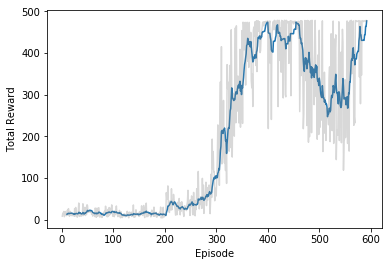

In [10]:
eps, rews = np.array(rewards_list).T
smoothed_rews = running_mean(rews, 10)
plt.plot(eps[-len(smoothed_rews):], smoothed_rews)
plt.plot(eps, rews, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total Reward')

## Watch a trained agent
Note that the episode ends after 500 steps.

In [11]:
def watch_agent(n_episodes):
    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/cartpole.ckpt")
        for episode in range(n_episodes):
            state = env.reset()
            r = 0
            while True:
                r += 1
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                action = np.argmax(Qs)
                state, reward, done, _ = env.step(action)
                env.render()
                sleep(0.05)
                # comment this if statement to see an endless episode
                if done:
                    env.close()
                    print(f"reward: {r}")
                    break

In [12]:
watch_agent(5)

INFO:tensorflow:Restoring parameters from checkpoints/cartpole.ckpt
reward: 500
reward: 500
reward: 500
reward: 500
reward: 500
